# Hello Bluesky: Reading detectors and scanning

In this notebook you will:

* Connect to some simulated hardware.
* Acquire some data via two common experimental procedures ("plans"), ``count`` and ``scan``.
* Write a custom plan.

Recommend Prerequisites:

* [Hello Python and Jupyter](./Hello%20Python%20and%20Jupyter.ipynb)

## Configuration
Below, we will connect to EPICS IOC(s) controlling simulated hardware in lieu of actual motors and detectors. An EPICS IOC is control system software that allows communication with a wide variety of hardware using a common interface. The IOCs should already be running in the background. Run this command to verify that they are running: it should produce output with RUNNING on each line. In the event of a problem, edit this command to replace `status` with `restart all` and run again.

In [1]:
%matplotlib widget

In [2]:
!supervisorctl -c supervisor/supervisord.conf status

decay                            RUNNING   pid 4777, uptime 0:01:24
mini_beamline                    RUNNING   pid 4778, uptime 0:01:24
random_walk                      RUNNING   pid 4779, uptime 0:01:24
random_walk_horiz                RUNNING   pid 4780, uptime 0:01:24
random_walk_vert                 RUNNING   pid 4781, uptime 0:01:24
simple                           RUNNING   pid 4782, uptime 0:01:24
thermo_sim                       RUNNING   pid 4783, uptime 0:01:24
trigger_with_pc                  RUNNING   pid 4784, uptime 0:01:24


In [3]:
%run scripts/beamline_configuration.py

/home/travis/virtualenv/python3.7.1/lib/python3.7/site-packages/pims/image_reader.py:26: RuntimeWarning: PIMS image_reader.py could not find scikit-image. Falling back to matplotlib's imread(), which uses floats instead of integers. This may break your scripts. 
(To ignore this warning, include the line "warnings.simplefilter("ignore", RuntimeWarning)" in your script.)
  warnings.warn(RuntimeWarning(ski_preferred))


In [4]:
# aliases for convenience/readability
motor = motor_ph
det = ph

Check that we can communicate with the hardware. If this doesn't raise an error, it worked.

In [5]:
det.wait_for_connection()

## Data Acquisition

### Executing a `count` plan with various parameters

In the example below, the Bluesky run engine is the interpreter of experiment plans and `count` is an experiment plan used here to acquire one reading from a point detector.

In [6]:
from bluesky.plans import count
RE(count([det]))



Transient Scan ID: 6     Time: 2020-06-26 20:30:09
Persistent Unique Scan ID: '4566d681-317e-466e-837a-827590b9a213'
New stream: 'primary'
+-----------+------------+------------+
|   seq_num |       time |     ph_det |
+-----------+------------+------------+
|         1 | 20:30:09.3 |      94846 |
+-----------+------------+------------+
generator count ['4566d681'] (scan num: 6)





('4566d681-317e-466e-837a-827590b9a213',)

The return value is a list of the run IDs that uniquely identify this data set. The "scan num" is easier to remember but is not good for long-term reference because it may not be unique.

Let's looks at the documentation for `count` to see what our other options are.

In [7]:
help(count)  # or, equiavently, type count? or ?count

Help on function count in module bluesky.plans:

count(detectors, num=1, delay=None, *, per_shot=None, md=None)
    Take one or more readings from detectors.
    
    Parameters
    ----------
    detectors : list
        list of 'readable' objects
    num : integer, optional
        number of readings to take; default is 1
    
        If None, capture data until canceled
    delay : iterable or scalar, optional
        Time delay in seconds between successive readings; default is 0.
    per_shot : callable, optional
        hook for customizing action of inner loop (messages per step)
        Expected signature ::
    
           def f(detectors: Iterable[OphydObj]) -> Generator[Msg]:
               ...
    
    md : dict, optional
        metadata
    
    Notes
    -----
    If ``delay`` is an iterable, it must have at least ``num - 1`` entries or
    the plan will raise a ``ValueError`` during iteration.



In [8]:
# Creating a figure explicitly in advance helps with the
# top-to-bottom flow of this notebook, but it is not necessary.
# If this is omitted, bluesky will cause a figure to appear
# during the RE(...) execution below.
plt.figure('ph_det vs time')

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

<Figure size 640x480 with 0 Axes>

In [9]:
# five consecutive readings
RE(count([det], num=5))



Transient Scan ID: 7     Time: 2020-06-26 20:30:09
Persistent Unique Scan ID: '7998714a-bdf3-4292-bafe-a4630d87c594'
New stream: 'primary'


+-----------+------------+------------+
|   seq_num |       time |     ph_det |
+-----------+------------+------------+
|         1 | 20:30:09.5 |      93516 |
|         2 | 20:30:09.5 |      93904 |
|         3 | 20:30:09.5 |      93199 |
|         4 | 20:30:09.6 |      93534 |
|         5 | 20:30:09.6 |      93890 |


+-----------+------------+------------+
generator count ['7998714a'] (scan num: 7)





('7998714a-bdf3-4292-bafe-a4630d87c594',)

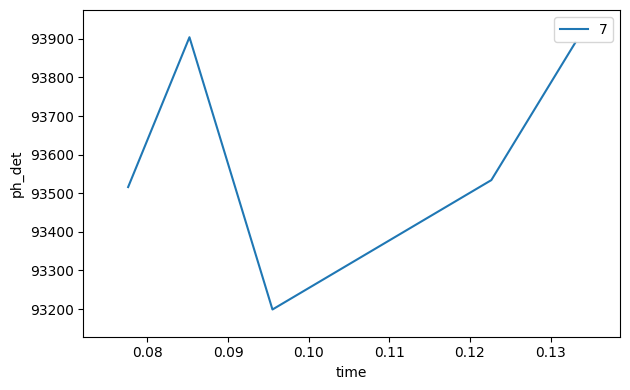

In [10]:
plt.gcf()  # Display a snapshot of the current state of the figure.

In [11]:
plt.gcf().canvas  # To avoid needing to scroll up, display the interactive canvas again here.

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [12]:
# five sequential readings separated by a 1-second delay
RE(count([det], num=5, delay=1))



Transient Scan ID: 8     Time: 2020-06-26 20:30:10
Persistent Unique Scan ID: 'dcb4cb9b-9525-436a-8ec7-78c803ad1b3b'
New stream: 'primary'
+-----------+------------+------------+
|   seq_num |       time |     ph_det |
+-----------+------------+------------+
|         1 | 20:30:10.1 |      93135 |


|         2 | 20:30:11.1 |     100322 |


|         3 | 20:30:12.1 |     102675 |


|         4 | 20:30:13.1 |      96207 |


|         5 | 20:30:14.1 |      93757 |


+-----------+------------+------------+
generator count ['dcb4cb9b'] (scan num: 8)





('dcb4cb9b-9525-436a-8ec7-78c803ad1b3b',)

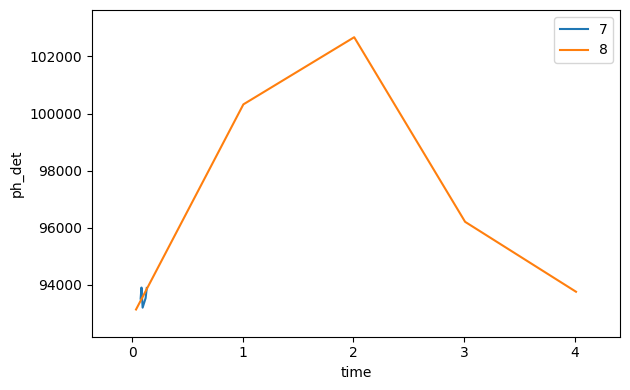

In [13]:
plt.gcf()  # Display a snapshot of the current state of the figure.

### Scan

Scan ``motor`` from -10 to 10, stopping at 15 equally-spaced points along the way and reading ``det``.

In [14]:
# Creating a figure explicitly in advance helps with the
# top-to-bottom flow of this notebook, but it is not necessary.
# If this is omitted, bluesky will cause a figure to appear
# during the RE(...) execution below.
plt.figure('ph_det vs motor_ph')

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

<Figure size 640x480 with 0 Axes>

In [15]:
RE(scan([det], motor, -10, 10, 15))



Transient Scan ID: 9     Time: 2020-06-26 20:30:15
Persistent Unique Scan ID: '378393c9-8ff0-4b1b-8de8-8487225e970e'


New stream: 'primary'
+-----------+------------+------------+------------+
|   seq_num |       time |   motor_ph |     ph_det |
+-----------+------------+------------+------------+
|         1 | 20:30:15.9 |    -10.000 |      14130 |
|         2 | 20:30:15.9 |     -8.571 |      24128 |
|         3 | 20:30:15.9 |     -7.143 |      38162 |
|         4 | 20:30:15.9 |     -5.714 |      55151 |
|         5 | 20:30:16.0 |     -4.286 |      72569 |


|         6 | 20:30:16.0 |     -2.857 |      89162 |
|         7 | 20:30:16.0 |     -1.429 |     101283 |
|         8 | 20:30:16.0 |      0.000 |     104502 |
|         9 | 20:30:16.0 |      1.429 |      99830 |
|        10 | 20:30:16.1 |      2.857 |      89251 |
|        11 | 20:30:16.1 |      4.286 |      72873 |
|        12 | 20:30:16.1 |      5.714 |      54230 |
|        13 | 20:30:16.1 |      7.143 |      37686 |
|        14 | 20:30:16.1 |      8.571 |      24206 |
|        15 | 20:30:16.1 |     10.000 |      14188 |
+-----------+------------+------------+------------+
generator scan ['378393c9'] (scan num: 9)





('378393c9-8ff0-4b1b-8de8-8487225e970e',)

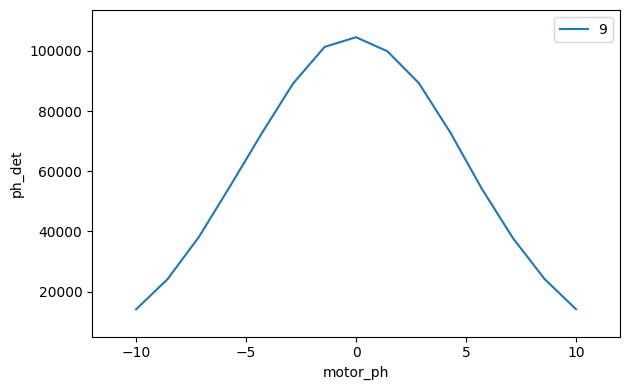

In [16]:
plt.gcf()  # Display a snapshot of the current state of the figure.

### Simulators

Bluesky includes utilities to inspecting plans before they are run. You can imagine various reasons you might want to do this. Example:

In [17]:
from bluesky.simulators import summarize_plan

summarize_plan(scan([det], motor, -1, 1, 3))

=================================== Open Run ===================================
motor_ph -> -1.0
  Read ['ph', 'motor_ph']
motor_ph -> 0.0
  Read ['ph', 'motor_ph']
motor_ph -> 1.0
  Read ['ph', 'motor_ph']
================================== Close Run ===================================


### Custom plan

Define a custom "plan", using the Python syntax ``yield from`` to dispatch out to built-in plans.

In [18]:
plt.gcf().canvas  # To avoid needing to scroll up, display the interactive canvas again here.

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [19]:
# The plan_stubs module contains smaller plans.
# They can be used alone or as buildling blocks for larger plans.
from bluesky.plan_stubs import mv


def sweep_exposure_time(times):
    "Multiple scans: one per exposure time setting."
    for t in times:
        yield from mv(det.exp, t)
        yield from scan([det], motor, -10, 10, 5)
        
RE(sweep_exposure_time([0.01, 0.1, 1]))



Transient Scan ID: 10     Time: 2020-06-26 20:30:16
Persistent Unique Scan ID: 'd9246baf-702d-4901-91df-280d81408569'


New stream: 'primary'
+-----------+------------+------------+------------+
|   seq_num |       time |   motor_ph |     ph_det |
+-----------+------------+------------+------------+
|         1 | 20:30:17.1 |    -10.000 |        120 |
|         2 | 20:30:17.2 |     -5.000 |        570 |


|         3 | 20:30:17.3 |      0.000 |        973 |
|         4 | 20:30:17.4 |      5.000 |        583 |


|         5 | 20:30:17.6 |     10.000 |        135 |
+-----------+------------+------------+------------+
generator scan ['d9246baf'] (scan num: 10)





Transient Scan ID: 11     Time: 2020-06-26 20:30:17
Persistent Unique Scan ID: '0ab807e0-60ab-45a1-9192-1089aded09b3'


New stream: 'primary'
+-----------+------------+------------+------------+
|   seq_num |       time |   motor_ph |     ph_det |
+-----------+------------+------------+------------+
|         1 | 20:30:18.1 |    -10.000 |       1360 |
|         2 | 20:30:18.2 |     -5.000 |       6041 |


|         3 | 20:30:18.4 |      0.000 |       9681 |
|         4 | 20:30:18.5 |      5.000 |       5870 |


|         5 | 20:30:18.6 |     10.000 |       1348 |
+-----------+------------+------------+------------+
generator scan ['0ab807e0'] (scan num: 11)





Transient Scan ID: 12     Time: 2020-06-26 20:30:18
Persistent Unique Scan ID: 'ee733e42-cadf-42c9-afe2-2bbf9b374e38'


New stream: 'primary'
+-----------+------------+------------+------------+
|   seq_num |       time |   motor_ph |     ph_det |
+-----------+------------+------------+------------+
|         1 | 20:30:19.2 |    -10.000 |      13755 |
|         2 | 20:30:19.3 |     -5.000 |      62795 |


|         3 | 20:30:19.4 |      0.000 |     104431 |
|         4 | 20:30:19.6 |      5.000 |      63589 |


|         5 | 20:30:19.7 |     10.000 |      14225 |
+-----------+------------+------------+------------+
generator scan ['ee733e42'] (scan num: 12)





('d9246baf-702d-4901-91df-280d81408569',
 '0ab807e0-60ab-45a1-9192-1089aded09b3',
 'ee733e42-cadf-42c9-afe2-2bbf9b374e38')

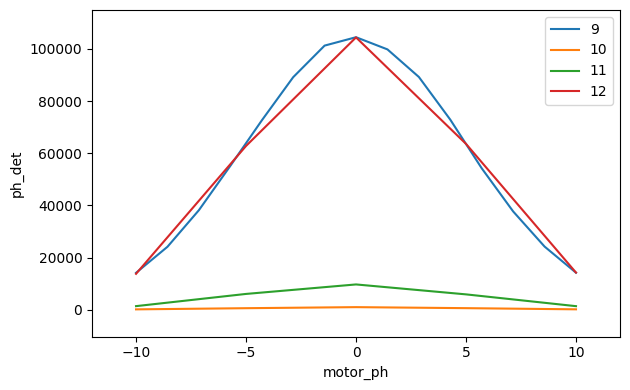

In [20]:
plt.gcf()  # Display a snapshot of the current state of the figure.

## Exercises

Q1: Above we ran a `count` with multiple readings separated by a fixed delay. The ``delay`` parameter also accepts a list of values. Try a `count` with a variable delay.


In [21]:
# Try your solution here. Fill in the blank:
# RE(count(____)))

Execute the following cell to reveal a solution:

In [22]:
%load solutions/count_variable_delay.py

Q2: Write a custom plan that scans the same region twice, first with coarse steps and then with fine steps.

In [23]:
# Try your solution here. Fill in the blank:
# def coarse_and_fine(detectors, motor, start, stop):
#     yield from scan(___)
#     yield from scan(___)
#
# RE(coarse_and_fine([det], motor, -10, 10))

In [24]:
%load solutions/scan_coarse_and_fine.py

Q3. All of the usages of scan we have seen so far scan from negative to positive. Scan from positive to negative.

In [25]:
# Try your solution here.

In [26]:
%load solutions/scan_positive_to_negative.py

Q4: The ``scan`` plan samples equally-spaced points. To sample *arbitrary* points, you can use ``list_scan``. Import it from the same module that we imported ``scan`` from, then use ``list_scan?`` to view its documentation and figure out how to use it. Scan the positions ``[1, 1, 2, 3, 5, 8]``.

In [27]:
# Try your solution here.

In [28]:
%load solutions/scan_fibonacci.py

Q5: What's wrong with this? (What does it do?)

In [29]:
# Broken example
def sweep_exposure_time(times):
    "Multiple scans: one per exposure time setting."
    for t in times:
        mv(det.exp, t)
        scan([det], motor, -10, 10, 15)

In [30]:
%load solutions/broken_sweep_exposure_time_explanation.txt